In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from IPython import display

# 看穿你的意圖(pytorch版)

In [2]:
import codecs
import numpy as np
import random
import pickle
import os
import math
os.environ['TRIDENT_BACKEND'] = 'pytorch'
#!pip install tridentx --upgrade
import trident as T
from trident import *

trident 0.7.0


Using Pytorch backend.
Image Data Format: channels_first.
Image Channel Order: rgb.
Pytorch version:1.7.0+cu110.
Automatic Mixed Precision Support:True.
Using pillow image backend.


Pillow version:7.1.2.


In [3]:
intent_data=codecs.open('Data/intent_list.txt',mode='r',encoding='utf-8-sig').readlines()
intent_dict={}
for i in range(len(intent_data)):
    intent_dict[i]=intent_data[i].strip() 
intent_dict

{0: '打開app應用',
 1: '詢問公車路線',
 2: '數學計算',
 3: '閒聊',
 4: '詢問電影場次',
 5: '查詢聯絡人',
 6: '查詢食譜',
 7: '詢問日期',
 8: '電子郵件指令',
 9: '詢問電視節目',
 10: '詢問航班',
 11: '詢問健康資訊',
 12: '詢問樂透',
 13: '詢問地圖',
 14: '詢問足球賽事',
 15: '簡訊指令',
 16: '音樂指令',
 17: '詢問新聞',
 18: '詢問小說',
 19: '詢問詩詞',
 20: '詢問廣播節目',
 21: '詢問謎語',
 22: '鬧鐘時程設定',
 23: '詢問股票',
 24: '電話指令',
 25: '詢問火車班次',
 26: '詢問翻譯',
 27: '切換電視頻道',
 28: '影片播放指令',
 29: '詢問天氣',
 30: '開啟網站'}

In [4]:
train_data=codecs.open('Data/TrainData.txt',mode='r',encoding='utf-8-sig').readlines()
maxlen=builtins.max([len(s) for s in train_data])
print("最大長度為:{0}".format(maxlen))
print(len(train_data))
print(train_data[:10])

最大長度為:52
2300
['打開博客來\t0\r\n', 'opera瀏覽器\t0\r\n', '開啟美圖秀秀\t0\r\n', '開啟zoom\t0\r\n', '幫我找功能選單\t0\r\n', '找一下憤怒鳥\t0\r\n', '現在打開相機\t0\r\n', '我把相機打開\t0\r\n', '你再line我\t0\r\n', '打開edge瀏覽器吧\t0\r\n']


In [5]:
test_data=codecs.open('Data/TestData.txt',mode='r',encoding='utf-8-sig').readlines()
maxlen=builtins.max([len(s) for s in test_data])
print("最大長度為:{0}".format(maxlen))
print(len(test_data))
print(test_data[:10])

最大長度為:69
1437
['打開我的瀏覽器\t0\r\n', '打開safari瀏覽器\t0\r\n', '打開kk播放器\t0\r\n', '啓動瀏覽器\t0\r\n', '他開bing\t0\r\n', '幫我搜索狼人殺\t0\r\n', '打開急速飛車\t0\r\n', '公共汽車查詢\t0\r\n', '打開新聞\t0\r\n', '圖庫\t0\r\n']


In [6]:
chars={}
with open('Data/hanzi2vec256.pkl','rb') as fp:
    chars = pickle.load(fp)
    
keys=list(sorted(list(chars.keys())))
embed=np.zeros((len(keys),256))
char2index={}
index2char={}

for i in range(len(keys)):
    embed[i]=chars[keys[i]]
    char2index[keys[i]]=i
    index2char[i]=keys[i]



    
embed=to_tensor(embed).to(get_device())
print(embed.shape)

torch.Size([21592, 256])


In [7]:
random.shuffle(train_data) #把訓練數據集順序打亂
random.shuffle(test_data) #把訓練數據集順序打亂
idx0=0
idx1=0
def data_augumentation(txt):
    txt=list(txt)
    #隨機對調字的順序
    if random.randint(0,10)<=3 and len(txt)>6:
        pos= random.randint(1,len(txt)-2)
        w1=txt[pos]
        w2=txt[pos+1]
        txt[pos]=w2
        txt[pos+1]=w1
    #隨機插入虛字    
    if random.randint(0,100)%7<=3 and len(txt)>=6:
        wordlist=['的','了','若','可','然','也','或','，','。',' ','  ']
        w1=random.choice(wordlist)
        txt.insert(random.randint(1,len(txt)-2), w1)
    #隨機插入標點
    if random.randint(0,100)%5<2:
        wordlist=['，','。','？','！',' ','  ']
        w1=random.choice(wordlist)
        txt.append(w1)
    return ''.join(txt)

def get_next_minibatch(minibatch_size=16,is_train=True):
    global idx0,idx1
    
    features = []
    labels = []
    groundtruths = []
    while len(features) < len(train_data if is_train else test_data):
        try:
            items=[]
            if is_train:
                items=train_data[idx0].strip().split('\t')
            else:
                items=test_data[idx1].strip().split('\t')
            txt=items[0]
            new_txt=txt
            if is_train:
                new_txt=data_augumentation(txt)
            lab=int(items[1])
            feature=np.zeros((256,128)) #預設都為零

            for i in range(128):
                if i< len(new_txt):
                    feature[:,i]=chars[new_txt[i].lower()] if new_txt[i].lower() in chars else np.random.standard_normal(256)
                    #替換為字向量，若是沒有這個字，填隨機亂數，剩餘保持為0
            features.append(feature)
            labels.append(lab)
            groundtruths.append(list(txt))
            if is_train:
                idx0 += 1
                if idx0 >= len(train_data):
                    idx0 = 0
                    random.shuffle(train_data)
            else:
                idx1 += 1
                if idx1 >= len(test_data):
                    idx1 = 0
                    random.shuffle(test_data)
        except Exception as e:
            print(e)
            
    return np.asarray(features).astype(np.float32), np.asarray(labels).astype(np.int64), groundtruths





In [8]:
features, labels, groundtruths = get_next_minibatch()
testfeatures, testlabels, testgroundtruths = get_next_minibatch(False)


data_provider=DataProvider(
    traindata=Iterator(data=NumpyDataset(data=features,symbol="features"), 
                       label=LabelDataset(labels=labels,symbol="labels")),
    testdata=Iterator(data=NumpyDataset(data=testfeatures,symbol="features"), 
                      label=LabelDataset(labels=testlabels,symbol="labels")))

data,label=data_provider.next()
print(data.shape)
print(len(data_provider))
print(data_provider.signature)

(8, 256, 128)
2300
data_provider( ) -> features: Tensor[(None, 256, 128)], labels: Tensor[(None,)] 


![md_images](../Images/textcnn.jpg)

In [9]:


textcnn=Sequential(
        Conv1d_Block(kernel_size=3,num_filters=512,strides=1,auto_pad=True,activation='leaky_relu',normalization='batch',dilation=1,dropout_rate=0.1),
                
        ConcateBlock(
            Sequential(
                Conv1d_Block(kernel_size=3,num_filters=512,strides=1,auto_pad=True,activation='leaky_relu',normalization='batch',dilation=1,dropout_rate=0.1),
                Conv1d_Block(kernel_size=3,num_filters=256,strides=1,auto_pad=True,activation='leaky_relu',normalization='batch')
            ),
            Sequential(
                Conv1d_Block(kernel_size=5,num_filters=512,strides=1,auto_pad=True,activation='leaky_relu',normalization='batch',dilation=1,dropout_rate=0.1),
                Conv1d_Block(kernel_size=3,num_filters=256,strides=1,auto_pad=True,activation='leaky_relu',normalization='batch')
            ),
            Sequential(
                Conv1d_Block(kernel_size=7,num_filters=512,strides=1,auto_pad=True,activation='leaky_relu',normalization='batch',dilation=1,dropout_rate=0.1),
                Conv1d_Block(kernel_size=3,num_filters=256,strides=1,auto_pad=True,activation='leaky_relu',normalization='batch')
            ),
            Sequential(
                Conv1d_Block(kernel_size=3,num_filters=512,strides=1,auto_pad=True,activation='leaky_relu',normalization='batch',dilation=3,dropout_rate=0.1),
                Conv1d_Block(kernel_size=3,num_filters=256,strides=1,auto_pad=True,activation='leaky_relu',normalization='batch')
            ),
            Sequential(
                Conv1d_Block(kernel_size=3,num_filters=512,strides=1,auto_pad=True,activation='leaky_relu',normalization='batch',dilation=6,dropout_rate=0.1),
                Conv1d_Block(kernel_size=3,num_filters=256,strides=1,auto_pad=True,activation='leaky_relu',normalization='batch')
            )
        ),
        Conv1d_Block(kernel_size=3,num_filters=256,strides=2,auto_pad=True,activation='leaky_relu',normalization='batch'),
        Conv1d_Block(kernel_size=3,num_filters=64,strides=2,auto_pad=True,activation='leaky_relu',normalization=None),
        Flatten(),
        Dense(len(intent_data)),
        SoftMax()
    )



In [10]:



model = Model(inputs=data, output=textcnn) \
    .with_optimizer(optimizer='Ranger', lr=1e-3, betas=(0.9, 0.999)) \
    .with_loss(CrossEntropyLoss, name='cross entropy') \
    .with_metric(accuracy, name='accuracy') \
    .with_regularizer('l2') \
    .with_constraint('min_max_norm') \
    .with_learning_rate_scheduler(reduce_lr_on_plateau, monitor='accuracy', mode='max', factor=0.75, patience=5, cooldown=1, threshold=1e-4, warmup=0) \
    .with_model_save_path('Models/textcnn.pth') \
    .with_automatic_mixed_precision_training()

model.summary()


cross entropy( output, target) -> cross entropy 
accuracy( output, target) -> accuracy 
Automatic Mixed Precision:Turn On.
--------------------------------------------------------------------------------------------------------------------------------
                   Layer (type)                          Output Shape               Weight           Bias    Param #            FLOPS #         
0.conv  Conv1d                                    [-1, 512, 128]           [512, 256, 3]               393,216 100,663,168.0            
0.norm  BatchNorm                                 [-1, 512, 128]           [512]               [512]   1,024   196,480.0                
0  Conv1d_Block                                   [-1, 512, 128]                                       0       0.0                      
1.branch1.0.conv  Conv1d                          [-1, 512, 128]           [512, 512, 3]               786,432 201,326,464.0            
1.branch1.0.norm  BatchNorm                       [-1, 

Model(
  (inputs): TensorSpec(dtype=torch.float32, shape=(None, 256, 128), ndim=3, name=input)
  (_outputs): TensorSpec(shape=(None, 31), ndim=2, name=output)
  (_targets): TensorSpec(shape=(None, 31), ndim=2, name=target)
  (_losses): <trident.optims.pytorch_losses.CrossEntropyLoss object at 0x0000016B01ED1E10>
  (_metrics): functools.partial(<function accuracy at 0x0000016AB3292D90>)
  (loss_weights): 1.0
  (_regs): functools.partial(<function l2_reg at 0x0000016AB214C8C8>)
  (_constraints): functools.partial(<function min_max_norm at 0x0000016AB3292AE8>)
)

In [11]:

print(data_provider.signature)

data_provider( ) -> features: Tensor[(None, 256, 128)], labels: Tensor[(None,)] 


In [12]:
print(model.signature)

( input: Tensor[(None, 256, 128)]) -> output: Tensor[(None, 31)] 


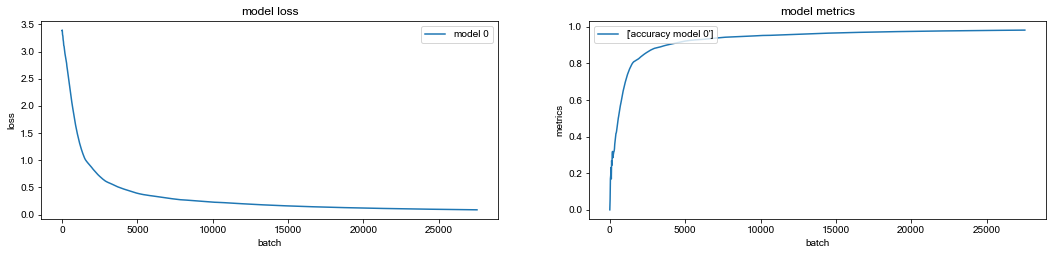

model 0      Step: 4s319ms  | Loss: 0.08819 | accuracy: 98.171%  | learning rate: 1.000e-03 | epoch: 95  ( 100/144 )
model 0      Step: 2s418ms  | Loss: 0.08813 | accuracy: 98.173%  | learning rate: 1.000e-03 | epoch: 95  ( 110/144 )
model 0      Step: 3s277ms  | Loss: 0.08806 | accuracy: 98.174%  | learning rate: 1.000e-03 | epoch: 95  ( 120/144 )
model 0           first_layer gradients: 1.973e-02| last_layer gradients: 1.037e-02
model 0      Step: 2s486ms  | Loss: 0.08800 | accuracy: 98.175%  | learning rate: 1.000e-03 | epoch: 95  ( 130/144 )
model 0      Step: 2s486ms  | Loss: 0.08794 | accuracy: 98.177%  | learning rate: 1.000e-03 | epoch: 95  ( 140/144 )
model 0: out-of-sample evaluation:  accuracy: 93.750% 
{ cross entropy: 1.017551312543219e-05, l2_reg_Loss: 0.001927618752233684, total_losses: 0.08763361722230911 }
model 0      Step: 1s247ms  | Loss: 0.08763 | accuracy: 98.183%  | learning rate: 1.000e-03 | epoch: 96  ( 0/144 )
model 0      Step: 2s451ms  | Loss: 0.08782 | accu

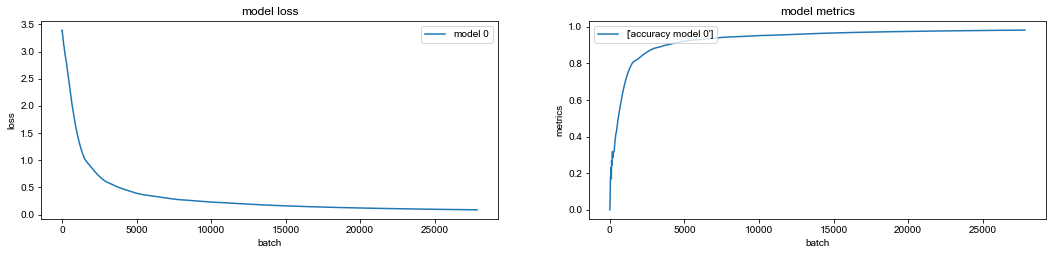

model 0      Step: 5s207ms  | Loss: 0.08729 | accuracy: 98.191%  | learning rate: 1.000e-03 | epoch: 96  ( 100/144 )
model 0      Step: 3s248ms  | Loss: 0.08723 | accuracy: 98.192%  | learning rate: 1.000e-03 | epoch: 96  ( 110/144 )
model 0      Step: 3s347ms  | Loss: 0.08717 | accuracy: 98.193%  | learning rate: 1.000e-03 | epoch: 96  ( 120/144 )
model 0           first_layer gradients: 2.014e-02| last_layer gradients: 6.770e-03
model 0      Step: 4s267ms  | Loss: 0.08711 | accuracy: 98.194%  | learning rate: 1.000e-03 | epoch: 96  ( 130/144 )
model 0      Step: 3s448ms  | Loss: 0.08705 | accuracy: 98.196%  | learning rate: 1.000e-03 | epoch: 96  ( 140/144 )
model 0: out-of-sample evaluation:  accuracy: 93.750% 
{ cross entropy: 1.99491614694125e-06, l2_reg_Loss: 0.0019125225953757763, total_losses: 0.08675004541873932 }
model 0      Step: 1s642ms  | Loss: 0.08675 | accuracy: 98.202%  | learning rate: 1.000e-03 | epoch: 97  ( 0/144 )
model 0      Step: 3s312ms  | Loss: 0.08693 | accu

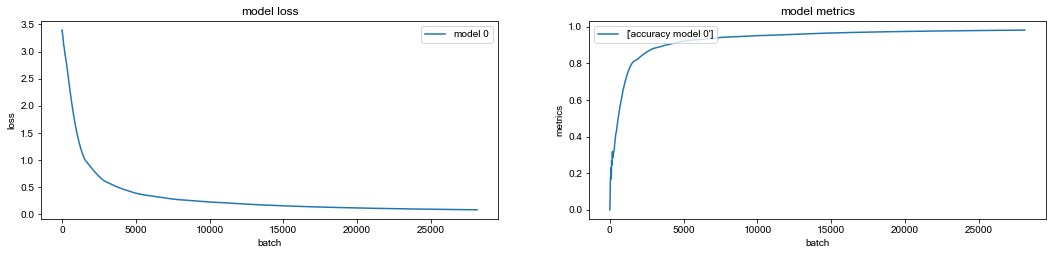

model 0      Step: 5s67ms   | Loss: 0.08642 | accuracy: 98.209%  | learning rate: 1.000e-03 | epoch: 97  ( 100/144 )
model 0      Step: 3s305ms  | Loss: 0.08636 | accuracy: 98.210%  | learning rate: 1.000e-03 | epoch: 97  ( 110/144 )
model 0      Step: 3s244ms  | Loss: 0.08630 | accuracy: 98.212%  | learning rate: 1.000e-03 | epoch: 97  ( 120/144 )
model 0      Step: 3s242ms  | Loss: 0.08624 | accuracy: 98.213%  | learning rate: 1.000e-03 | epoch: 97  ( 130/144 )
model 0           first_layer gradients: 3.492e-02| last_layer gradients: 6.762e-03
model 0      Step: 4s293ms  | Loss: 0.08618 | accuracy: 98.214%  | learning rate: 1.000e-03 | epoch: 97  ( 140/144 )
model 0: out-of-sample evaluation:  accuracy: 93.750% 
{ cross entropy: 9.741982012201333e-07, l2_reg_Loss: 0.0018965720664709806, total_losses: 0.08588435500860214 }
model 0      Step: 1s593ms  | Loss: 0.08588 | accuracy: 98.221%  | learning rate: 1.000e-03 | epoch: 98  ( 0/144 )
model 0      Step: 3s278ms  | Loss: 0.08606 | acc

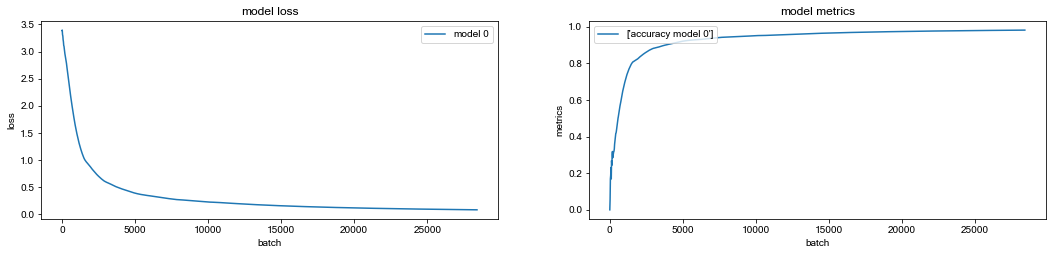

model 0      Step: 5s189ms  | Loss: 0.08556 | accuracy: 98.228%  | learning rate: 1.000e-03 | epoch: 98  ( 100/144 )
model 0      Step: 3s353ms  | Loss: 0.08550 | accuracy: 98.229%  | learning rate: 1.000e-03 | epoch: 98  ( 110/144 )
model 0      Step: 3s621ms  | Loss: 0.08544 | accuracy: 98.230%  | learning rate: 1.000e-03 | epoch: 98  ( 120/144 )
model 0      Step: 3s354ms  | Loss: 0.08538 | accuracy: 98.231%  | learning rate: 1.000e-03 | epoch: 98  ( 130/144 )
model 0           first_layer gradients: 3.496e-02| last_layer gradients: 5.070e-03
model 0      Step: 4s238ms  | Loss: 0.08532 | accuracy: 98.233%  | learning rate: 1.000e-03 | epoch: 98  ( 140/144 )
model 0: out-of-sample evaluation:  accuracy: 100.000%
{ cross entropy: 7.972595312821795e-07, l2_reg_Loss: 0.0018797360826283693, total_losses: 0.08503597974777222 }
model 0      Step: 1s673ms  | Loss: 0.08504 | accuracy: 98.239%  | learning rate: 1.000e-03 | epoch: 99  ( 0/144 )
model 0      Step: 3s346ms  | Loss: 0.08521 | acc

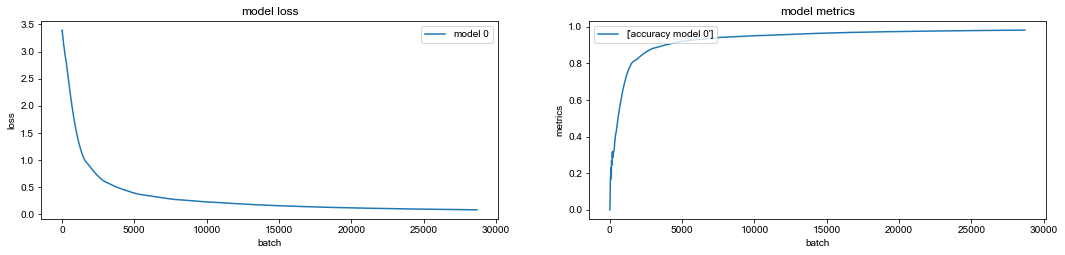

model 0      Step: 6s166ms  | Loss: 0.08472 | accuracy: 98.245%  | learning rate: 1.000e-03 | epoch: 99  ( 100/144 )
model 0      Step: 3s373ms  | Loss: 0.08466 | accuracy: 98.247%  | learning rate: 1.000e-03 | epoch: 99  ( 110/144 )
model 0      Step: 3s481ms  | Loss: 0.08460 | accuracy: 98.248%  | learning rate: 1.000e-03 | epoch: 99  ( 120/144 )
model 0      Step: 3s342ms  | Loss: 0.08454 | accuracy: 98.249%  | learning rate: 1.000e-03 | epoch: 99  ( 130/144 )
model 0      Step: 3s302ms  | Loss: 0.08449 | accuracy: 98.250%  | learning rate: 1.000e-03 | epoch: 99  ( 140/144 )
model 0: out-of-sample evaluation:  accuracy: 100.000%


In [12]:

plan=TrainingPlan()\
    .add_training_item(model)\
    .with_data_loader(data_provider)\
    .repeat_epochs(100)\
    .within_minibatch_size(16)\
    .print_progress_scheduling(10,unit='batch')\
    .display_loss_metric_curve_scheduling(frequency=100,unit='batch',imshow=True)\
    .print_gradients_scheduling(50)\
    .save_model_scheduling(50,unit='batch')\
    .within_tensorboard()

plan.start_now()

In [56]:
model.eval()
model.save_onnx('Models/text_cnn.onnx')

我們已經將模型匯出成為onnx格式，要使用它來做推論的步驟其實非常簡單，首先要匯入onnxruntime的包，然後將模型載入至推論session中。

In [57]:
import onnx
import onnxruntime as ort

#載入onnx模型進行檢查，不需要每次都做，只要轉檔後做一次即可
predictor = onnx.load('Models/text_cnn.onnx')
print(onnx.checker.check_model(predictor))


None


In [58]:
#載入onnx模型至onnxruntime
ort_session = ort.InferenceSession('Models/text_cnn.onnx')
#取出輸入張量形狀
input_name = ort_session.get_inputs()[0].name
input_name

'input'

In [65]:
txt='今天台積電股價是多少?'
def sentance2tensor(words):
    feature=np.zeros((256,128)) #預設都為零
    for i in range(128):
        if i< len(words):
            feature[:,i]=chars[words[i].lower()] if words[i].lower() in chars else np.random.standard_normal(256)
    return expand_dims(feature,0).astype(np.float32)


print(sentance2tensor(txt).shape)

(1, 256, 128)


In [82]:
#把剛才流程包成函數
def sentence2intent(words):
    #透過onnx進行推論
    pred_intent= ort_session.run(None, {input_name:sentance2tensor(words)})[0]

    #透過argmax找出機率最高前三名的意圖索引位置
    idx=argsort(pred_intent,-1)[::-1][0][:3]

    #列印出意圖名稱以及機率
    result=OrderedDict()
    for i in range(3):
        result[i]=(intent_dict[idx[i]],pred_intent[0][idx[i]])
    return result

sentence2intent(txt)

{ 0: ('詢問股票', 0.9999994), 1: ('詢問電視節目', 5.855678e-07), 2: ('打開app應用', 3.2424852e-10) }

In [83]:
pred_intent= ort_session.run(None, {input_name:sentance2tensor('打開谷歌硬碟')})[0]
idx1=argmax(pred_intent,-1)[0]
sentence2intent('打開谷歌硬碟')

{ 0: ('開啟網站', 0.86599094), 1: ('打開app應用', 0.13395746), 2: ('切換電視頻道', 4.5926594e-05) }

我們可以試著一些不正常的問法，例如錯字，字的順序對調以及簡稱，模型仍然可以正確地回復

In [89]:
print(sentence2intent('水煮魚怎魔煮'))
print(sentence2intent('晚上到雄高的火車出發時刻'))
print(sentence2intent('台車該麼走'))
print(sentence2intent('今天台灣確診人數是幾名啊'))

{ 0: ('查詢食譜', 0.9998703), 1: ('詢問翻譯', 0.000101466314), 2: ('切換電視頻道', 1.1400427e-05) }
{ 0: ('詢問火車班次', 0.9999969), 1: ('詢問地圖', 2.1576911e-06), 2: ('詢問公車路線', 9.2781755e-07) }
{ 0: ('詢問地圖', 0.76722413), 1: ('詢問股票', 0.12598895), 2: ('閒聊', 0.0711749) }
{ 0: ('詢問電視節目', 0.52811635), 1: ('閒聊', 0.47155616), 2: ('詢問謎語', 0.00019114868) }


In [96]:
np.save('Models/embed.npy',to_numpy(embed),allow_pickle=True)


with open("Models/charlist.txt",mode='w',encoding='utf-8-sig') as f:
    f.write(''.join(keys))
